In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn import svm
import seaborn as sns; sns.set()
model = svm.SVR()

AMZN = pd.read_csv("AMZN202102.csv")
AAPL = pd.read_csv("AAPL202102.csv")
AMZN.Date = pd.to_datetime(AMZN.Date)
AAPL.Date = pd.to_datetime(AAPL.Date)
AMZN.set_index("Date", inplace=True)
AAPL.set_index("Date", inplace=True)
AMZN_price = AMZN[['Close']]
AAPL_price = AAPL[['Close']]

test_start =  '2020-11-01'

AMZN_price[['Close']].rename(columns={'Close':'train'}) \
    .join(AMZN_price[test_start:][['Close']].rename(columns={'Close':'test'}), how='outer')

AAPL_price[['Close']].rename(columns={'Close':'train'}) \
    .join(AAPL_price[test_start:][['Close']].rename(columns={'Close':'test'}), how='outer')

K = 5
HORIZON = 1
y = ['Close_t+1']
X = ['Close_t-{}'.format(idx) for idx in range(0, K)]

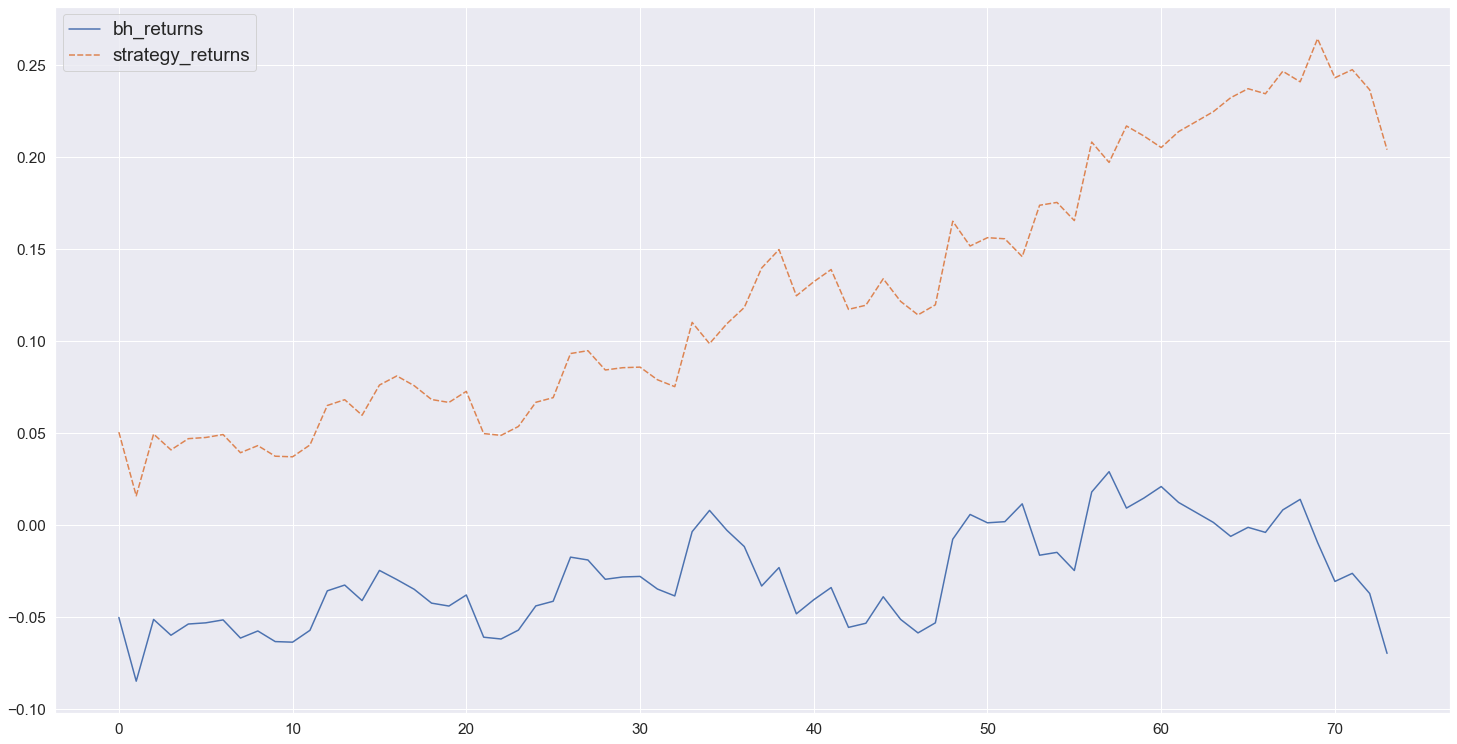

In [2]:
AMZNtrain = AMZN_price[:test_start].copy()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
AMZNtrain['Close'] = scaler.fit_transform(AMZNtrain)

trainshift = AMZNtrain.copy()
trainshift['Close_t+1'] = AMZNtrain['Close'].shift(-1)
trainshift.head(2)
for t in range(K):
    trainshift['Close_t-{}'.format(t)] = trainshift['Close'].shift(t)
trainshift = trainshift.dropna(how='any')
trainshift.head(5)

y_train = trainshift[y].values
X_train = trainshift[X].values

model.fit(X_train,np.ravel(y_train,order='C'))

AMZNtest = AMZN_price[test_start:].copy()
AMZNtest['Close'] = scaler.transform(AMZNtest)
Testshift = AMZNtest.copy()
Testshift['Close_t+1'] = Testshift['Close'].shift(-1)
for t in range(0, K):
     Testshift['Close_t-{}'.format(t)] = Testshift['Close'].shift(t)
test_shifted = Testshift.dropna(how='any')
y_col = ['Close_t+1']
X_cols = ['Close_t-{}'.format(idx) for idx in range(0, K)]
y_test = test_shifted[y_col].values
X_test = test_shifted[X_cols].values

pred=model.predict(X_test)


AMZN_evaluation = pd.DataFrame(pred, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
AMZN_evaluation['Date'] = test_shifted.index
AMZN_evaluation = pd.melt(AMZN_evaluation, id_vars='Date', value_name='prediction', var_name='h')
AMZN_evaluation['actual'] = np.transpose(y_test).ravel()
AMZN_evaluation[['prediction', 'actual']] = scaler.inverse_transform(AMZN_evaluation[['prediction', 'actual']])
AMZN_evaluation.head()

all_df = AMZN_evaluation.merge(AMZN[['Close']],on="Date", how='inner')

all_df['signal'] = 0
# use 1 to indicate long (buy), -1 to indicate short (sell)
all_df.loc[all_df.Close<all_df.prediction,'signal'] = 1
all_df.loc[all_df.Close>all_df.prediction,'signal'] = -1
all_df['bh_returns'] = (all_df['Close'].shift(-1)- all_df['Close'])/all_df['Close']
cum_bh_returns = np.cumsum(all_df['bh_returns'])


all_df['strategy_returns'] = all_df['bh_returns']* all_df['signal']
cum_strategy_returns = np.cumsum(all_df['strategy_returns'])
newdf = pd.concat([cum_bh_returns, cum_strategy_returns], axis=1)
plt.figure(figsize=(25, 13))
sns.set(font_scale=1.4) 
ax = sns.lineplot(data=newdf)
plt.setp(ax.get_legend().get_texts(), fontsize='19')
plt.savefig('returns.png', dpi=300)

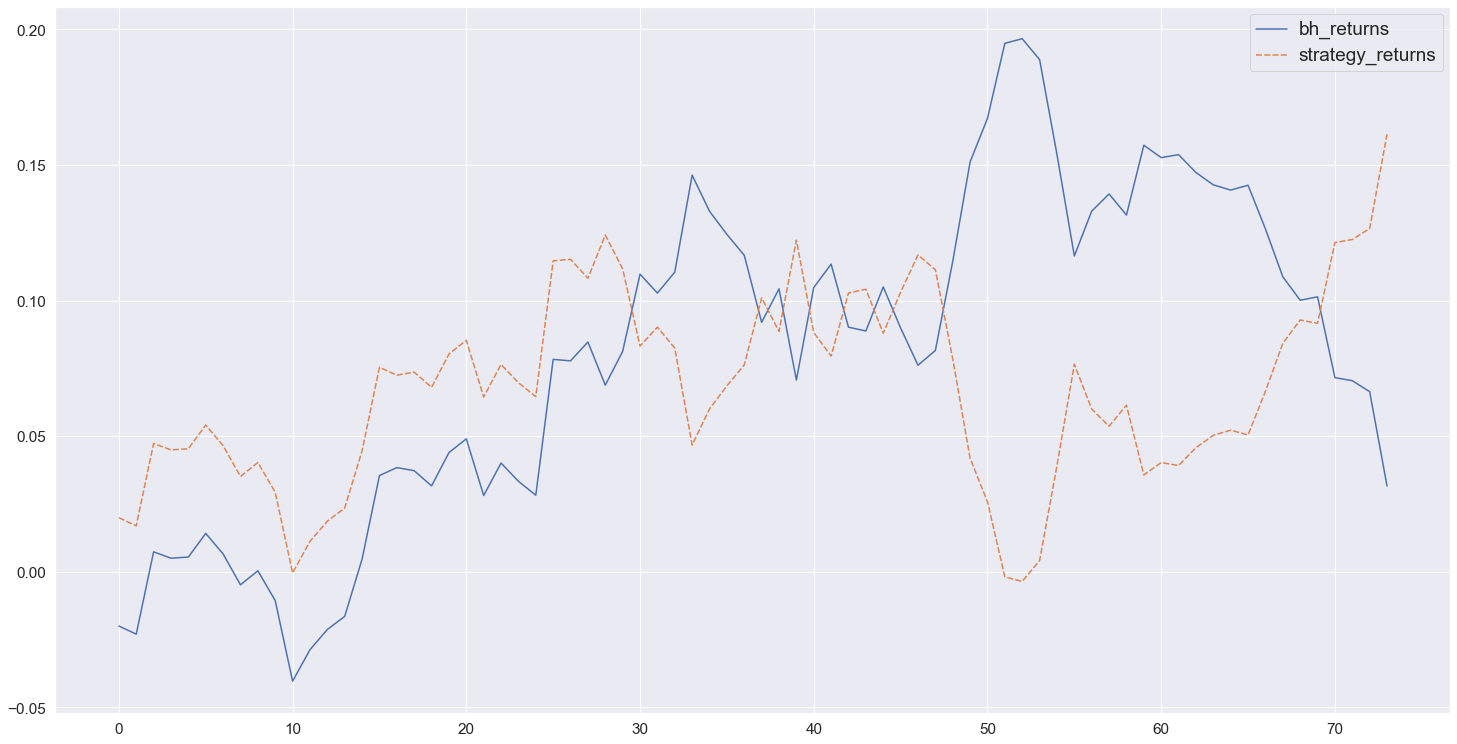

In [3]:
AAPLtrain = AAPL_price[:test_start].copy()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
AAPLtrain['Close'] = scaler.fit_transform(AAPLtrain)

trainshift = AAPLtrain.copy()
trainshift['Close_t+1'] = AAPLtrain['Close'].shift(-1)
trainshift.head(2)
for t in range(K):
    trainshift['Close_t-{}'.format(t)] = trainshift['Close'].shift(t)
trainshift = trainshift.dropna(how='any')
trainshift.head(5)

y_train = trainshift[y].values
X_train = trainshift[X].values

model.fit(X_train,np.ravel(y_train,order='C'))

AAPLtest = AAPL_price[test_start:].copy()
AAPLtest['Close'] = scaler.transform(AAPLtest)
Testshift = AAPLtest.copy()
Testshift['Close_t+1'] = Testshift['Close'].shift(-1)
for t in range(0, K):
     Testshift['Close_t-{}'.format(t)] = Testshift['Close'].shift(t)
test_shifted = Testshift.dropna(how='any')
y_col = ['Close_t+1']
X_cols = ['Close_t-{}'.format(idx) for idx in range(0, K)]
y_test = test_shifted[y_col].values
X_test = test_shifted[X_cols].values

pred=model.predict(X_test)


AAPL_evaluation = pd.DataFrame(pred, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
AAPL_evaluation['Date'] = test_shifted.index
AAPL_evaluation = pd.melt(AAPL_evaluation, id_vars='Date', value_name='prediction', var_name='h')
AAPL_evaluation['actual'] = np.transpose(y_test).ravel()
AAPL_evaluation[['prediction', 'actual']] = scaler.inverse_transform(AAPL_evaluation[['prediction', 'actual']])
AAPL_evaluation.head()

all_df = AAPL_evaluation.merge(AAPL[['Close']],on="Date", how='inner')

all_df['signal'] = 0
# use 1 to indicate long (buy), -1 to indicate short (sell)
all_df.loc[all_df.Close<all_df.prediction,'signal'] = 1
all_df.loc[all_df.Close>all_df.prediction,'signal'] = -1
all_df['bh_returns'] = (all_df['Close'].shift(-1)- all_df['Close'])/all_df['Close']
cum_bh_returns = np.cumsum(all_df['bh_returns'])


all_df['strategy_returns'] = all_df['bh_returns']* all_df['signal']
cum_strategy_returns = np.cumsum(all_df['strategy_returns'])
newdf = pd.concat([cum_bh_returns, cum_strategy_returns], axis=1)
plt.figure(figsize=(25, 13))
sns.set(font_scale=1.4) 
ax = sns.lineplot(data=newdf)
plt.setp(ax.get_legend().get_texts(), fontsize='19')
plt.savefig('returns.png', dpi=300)